# SSNN network training
### very unstable

In [20]:
import torch
import matplotlib.pyplot as plt
from ssnn import SSNN

In [21]:
# Create dataset
# train
x_train = torch.arange(0, 100, 0.5)
x_train = x_train.unfold(0, 20, 1)
x_train = x_train.unsqueeze(-1)

y_train = x_train[:,-1,:]
x_train = x_train[:,0:-1,:]

x_train = 5*torch.sin(x_train)
y_train = 5*torch.sin(y_train)

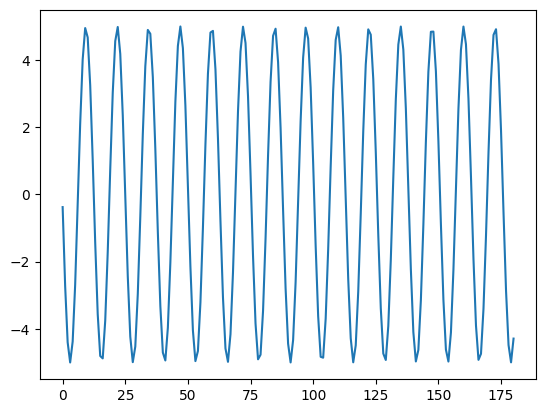

In [22]:
plt.plot(y_train.squeeze())

In [23]:
ssnn = SSNN(1, 5, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(ssnn.parameters(), lr=0.001, momentum=0.9)

In [24]:
# training loop
t_loss = []

for epoch in range(300):  # loop over the dataset multiple times
    optimizer.zero_grad()

    outputs = ssnn(x_train)
    outputs = outputs[:, -1, :]
    loss = criterion(outputs, y_train)

    t_loss.append(loss.item())

    loss.backward()
    optimizer.step()

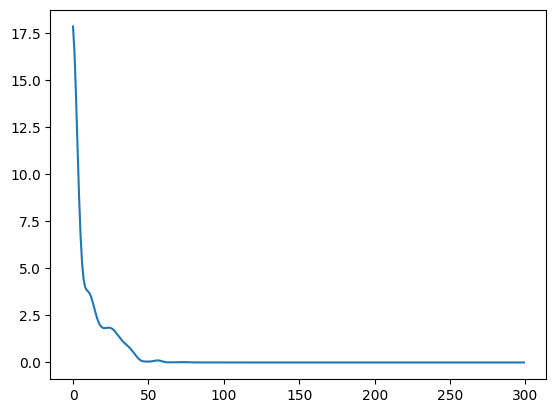

In [25]:
plt.plot(t_loss)

In [26]:
def observability(A:torch.Tensor, C:torch.Tensor):
    with torch.no_grad():
        O = torch.zeros(A.shape[0], C.shape[1])
        for row in range(len(O)):
            O[row] = torch.matmul(C, torch.linalg.matrix_power(A, row))
    return O

O = observability(ssnn.A, ssnn.C)
print(f"Observability matrix O:\n", O)

print(f"Determinant of O", torch.linalg.det(O))

Observability matrix O:
 tensor([[-0.2679,  0.6016,  0.6670,  0.3872, -0.4533],
        [ 0.1300,  0.5796, -0.5562,  0.0396,  0.5316],
        [ 0.0789, -0.1281, -0.2138,  0.1208,  0.1902],
        [ 0.0214, -0.1540,  0.0173, -0.0599, -0.0984],
        [-0.0354, -0.0356,  0.0915, -0.0042, -0.0812]])
Determinant of O tensor(-8.5449e-05)


# LSTM

In [27]:
class lstm_linear(torch.nn.Module):
    def __init__(self, u_len:int, x_len:int, y_len:int):
        super(lstm_linear, self).__init__()
        
        self.lstm = torch.nn.LSTM(u_len, x_len, batch_first=True)
        self.linear = torch.nn.Linear(x_len, y_len)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        y = self.linear(out)
        return y

lstm = lstm_linear(1, 20, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr=0.001, momentum=0.9)

In [28]:
# training loop
t_loss = []

loss = 0
for epoch in range(300):  # loop over the dataset multiple times
    optimizer.zero_grad()

    outputs = lstm(x_train)

    loss = criterion(outputs, y_train)

    t_loss.append(loss.item())

    loss.backward()
    optimizer.step()

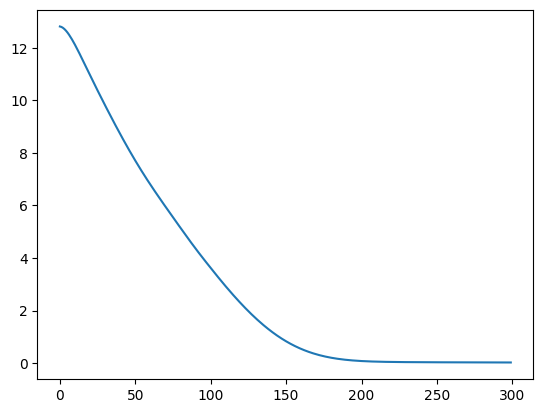

In [29]:
plt.plot(t_loss)

## eval comparation

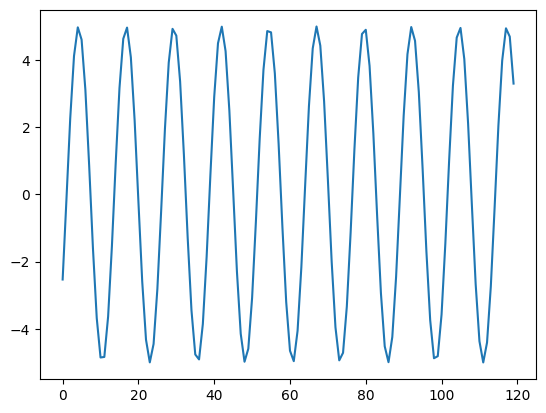

In [30]:
# eval
x_eval = torch.arange(100, 110, 0.5)
x_eval = x_eval.unsqueeze(-1)
x_eval = x_eval.unsqueeze(0)

y_eval = 5*torch.sin(x_eval)
y_eval_ssnn = y_eval

# eval
for t in range(100):
    with torch.no_grad():
        y_eval_ssnn = torch.cat((y_eval_ssnn, ssnn(y_eval_ssnn[:, t:20+t, :])[:,-1,:].unsqueeze(-1)), dim=1)

plt.plot(y_eval_ssnn.squeeze())

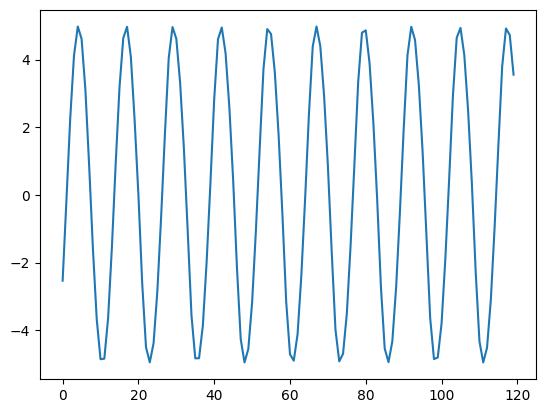

In [31]:
# eval
x_eval = torch.arange(100, 110, 0.5)
x_eval = x_eval.unsqueeze(-1)
x_eval = x_eval.unsqueeze(0)

y_eval = 5*torch.sin(x_eval)
y_eval_lstm = y_eval

# eval
for t in range(100):
    with torch.no_grad():
        y_eval_lstm = torch.cat((y_eval_lstm, lstm(y_eval_lstm[:, t:20+t, :]).unsqueeze(-1)), dim=1)

plt.plot(y_eval_lstm.squeeze())